# Multiple Linear Regression with Time Series Analysis and Pandas Resampling

 The objective behind this exercise is to forecast weekly sales across several Walmart stores in the US using Time Series Analysis. We have features of several types that go into the prediction of our response variable  

We will also estimate sales in each quarter for all stores and address the following question: **which stores experienced the highest and lower Quarter-Quarter sales %increase and %decline in any given period**

In [1]:
#import relevant packages and files into the Jupyter Lab Environment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

consumer_features = pd.read_csv("Walmart.csv")
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
print('This dataset has {} rows and {} columns'.format(consumer_features.shape[0], consumer_features.shape[1]))
consumer_features.head(n = 15)

This dataset has 6435 rows and 8 columns


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


The Walmart dataset has several features denoting what goes into forecasting **Weekly Sales**. We will explore our other datasets too.

In [3]:
print('This dataset has {} rows and {} columns'.format(stores.shape[0], stores.shape[1]))
stores.head(n = 15)

This dataset has 45 rows and 3 columns


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [4]:
print('This dataset has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
train.head(n = 15) #contains the training data

This dataset has 421570 rows and 5 columns


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [5]:
print('This dataset has {} rows and {} columns'.format(test.shape[0], test.shape[1]))
test.head(n = 15) #contains the test data

This dataset has 115064 rows and 4 columns


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
5,1,1,2012-12-07,False
6,1,1,2012-12-14,False
7,1,1,2012-12-21,False
8,1,1,2012-12-28,True
9,1,1,2013-01-04,False


## Data Wrangling and Features Engineering

First, we must merge our dataframes and filter out irrelevant predictors to obtain a single dataframe more informative which will be used for further analysis.

In [6]:
#Merge the attributes in the Store dataset with the training set for prediction.

train_stores = pd.merge(train,stores, how = 'inner')
train_stores

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221
421566,45,98,2012-10-05,628.10,False,B,118221
421567,45,98,2012-10-12,1061.02,False,B,118221
421568,45,98,2012-10-19,760.01,False,B,118221


In [7]:
#The 'Type' column is redundant as it doesn't convey any useful information for sales forecasting so we can discard it.

train_stores.drop(columns = 'Type', inplace = True)

Finally, looking at the consumer features dataset, it is clear that out of the four possible predictors to include - Temperature, CPI, Unemployment, Fuel_Price, the only useful predictor to consider would be 'Temperature' since the outside temperature not only affects the number and frequency of shoppers visiting Walmart stores, but also the peak hours of operation (for instance, during Winter, most visits will take place during the morning/afternoon hours when it is warmer and sunnier outside).

Thus we will attempt to include 'Temperature' as a feature in our training data; however, we must first ensure that all dates follow consistent formatting across both the **train_stores** and **consumer_features** datasets. Upon first glance, the dates appear to be in different formats, so I will attempt to ensure formatting consistency before merging 'Temperature' with the train_stores dataframe.

In [8]:
consumer_features['Date'] = pd.to_datetime(consumer_features['Date']).dt.strftime('%Y-%m-%d')
consumer_features['Date']

0       2010-05-02
1       2010-12-02
2       2010-02-19
3       2010-02-26
4       2010-05-03
           ...    
6430    2012-09-28
6431    2012-05-10
6432    2012-12-10
6433    2012-10-19
6434    2012-10-26
Name: Date, Length: 6435, dtype: object

In [9]:
#The First two rows are improperly formatted but the rest are fine. We will change the formatting of these entires
consumer_features.loc[[0,1], 'Date'] = ['2010-02-05', '2010-02-12']

In [10]:
#Now, we will proceed to merge consumer_features with train_stores to add Temperature as a predictor
df_train = pd.merge(train_stores, consumer_features, on = ['Date', 'Store'], how = 'left')

In [11]:
#dropping the redundant columns

df_train.drop(columns = ['Holiday_Flag', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_y'], inplace = True)
df_train.rename(columns = {'Weekly_Sales_x' : 'Weekly_Sales'}, inplace = True)
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature
0,1,1,2010-02-05,24924.50,False,151315,42.31
1,1,1,2010-02-12,46039.49,True,151315,38.51
2,1,1,2010-02-19,41595.55,False,151315,39.93
3,1,1,2010-02-26,19403.54,False,151315,46.63
4,1,1,2010-03-05,21827.90,False,151315,NaN
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,118221,64.88
421566,45,98,2012-10-05,628.10,False,118221,NaN
421567,45,98,2012-10-12,1061.02,False,118221,NaN
421568,45,98,2012-10-19,760.01,False,118221,56.47


In [12]:
#check for missing values and datatypes

pd.DataFrame({'Missing values % in each column':((pd.isnull(df_train).sum()/len(df_train))*100)}).reset_index()



,index,Missing values % in each column
0,Store,0.000000
1,Dept,0.000000
2,Date,0.000000
3,Weekly_Sales,0.000000
4,IsHoliday,0.000000
5,Size,0.000000
6,Temperature,32.839386


Since a third of the values in our Temperature column are missing, we need a proper imputation strategy to deal with them
#as we cannot risk dropping any single datapoint (corresponding to a week) due to its requirement for Time Series Analysis. Thus, we will attempt to interpolate to infer the missing values in the Temperature column of out dataset.

In [13]:
df_train.interpolate(method = 'linear', inplace = True)
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature
0,1,1,2010-02-05,24924.50,False,151315,42.310000
1,1,1,2010-02-12,46039.49,True,151315,38.510000
2,1,1,2010-02-19,41595.55,False,151315,39.930000
3,1,1,2010-02-26,19403.54,False,151315,46.630000
4,1,1,2010-03-05,21827.90,False,151315,47.950000
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,118221,64.880000
421566,45,98,2012-10-05,628.10,False,118221,62.076667
421567,45,98,2012-10-12,1061.02,False,118221,59.273333
421568,45,98,2012-10-19,760.01,False,118221,56.470000


In [14]:
# Proceeding to check the datatypes of all columns
df_train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Size              int64
Temperature     float64
dtype: object

In [15]:
#Performing appropriate datatype conversions of the columns to their correct types and setting the date column 
#to be the index of our dataframe for Time Series Analysis
df_train['Store'] = df_train['Store'].astype('category')
df_train['Dept'] = df_train['Dept'].astype('category')
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace = True)

Finally, we should group our test dataframe by date to determine how many periods into the future we must forecast.

In [16]:
df_test = test.groupby(['Date']).mean()
print('We should forcast {} weeks into the future'.format(df_test.shape[0]))

We should forcast 39 weeks into the future


## Exploratory Data Analysis

In [17]:
df_train.describe() #descriptive statistics about our dataframe

,Weekly_Sales,Size,Temperature
count,421570.000000,421570.000000,421570.000000
mean,15981.258123,136727.915739,60.311183
std,22711.183519,60980.583328,17.737183
min,-4988.940000,34875.000000,5.540000
25%,2079.650000,93638.000000,47.880000
50%,7612.030000,140167.000000,62.030000
75%,20205.852500,202505.000000,73.710000
max,693099.360000,219622.000000,100.140000


In [18]:
#negative weekly store sales are clearly erroneous and should be investigated further. 

df_train[df_train['Weekly_Sales'] <= 0]['Weekly_Sales'].describe()

count    1358.000000
mean      -64.920147
std       225.877919
min     -4988.940000
25%       -38.000000
50%       -12.000000
75%        -3.855000
max         0.000000
Name: Weekly_Sales, dtype: float64

In addition to highly negative values, we are have sales figures that do not make sense. For example, it is not practical for some stores to make just 12 dollars worth of total sales in a week. First, I will convert all negative values to positive and then decide on a strategy to deal with outliers.

In [19]:
df_train['Weekly_Sales'] = abs(df_train['Weekly_Sales'])
df_train['Weekly_Sales'].describe()

count    421570.000000
mean      15981.676377
std       22710.889199
min           0.000000
25%        2079.757500
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

Since 25% of the stores in our data experienced weekly sales below 2080, winsoiring store sales below 1000 seems like a suitable strategy for dealing with misleading sales figures.

In [20]:
df_train['Weekly_Sales'] = df_train['Weekly_Sales'].apply(lambda x: 1000 if x < 1000 else x)
df_train['Weekly_Sales'].describe()

count    421570.000000
mean      16101.304229
std       22629.362424
min        1000.000000
25%        2079.757500
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

The data is segregated based on the store and department so we would have the same three year window repeat for each store-department combination. It would make sense to first group our data based on store and department to represent the sum total of weekly sales across all stores and departments for a given date. This would allow us to accurately visualize the underlying trends and patterns in our sales data.

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Count'>

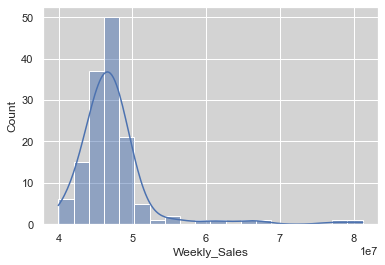

In [21]:
df_train_grouped = df_train.groupby(['Date']).sum()
sns.set(rc={'axes.facecolor':'lightgrey'})
sns.histplot(data = df_train_grouped, x = "Weekly_Sales", bins = 20, kde = True, color = 'b')

The data appears to be significantly right skewed. One way to tackle this issue is through a log transformation.

In [22]:
log_transformed_sales = np.log(df_train_grouped['Weekly_Sales'])
log_transformed_sales

Date
2010-02-05    17.729425
2010-02-12    17.700402
2010-02-19    17.699402
2010-02-26    17.607214
2010-03-05    17.670355
                ...    
2012-09-28    17.601844
2012-10-05    17.684777
2012-10-12    17.654759
2012-10-19    17.632211
2012-10-26    17.641589
Name: Weekly_Sales, Length: 143, dtype: float64

Finally, we will inspect the grouped dataframe and change columns such as 'Temperature', 'Size', 'IsHoliday' to reflect meaningful values.

In [23]:
df_train_grouped_avg = df_train.groupby(['Date']).mean()
df_train_grouped.loc[:, ['IsHoliday', 'Size', 'Temperature']] = df_train_grouped_avg.loc[:, ['IsHoliday', 'Size', 'Temperature']]
df_train_grouped

,Weekly_Sales,IsHoliday,Size,Temperature
Date,,,,
2010-02-05,50094641.72,0.0,137430.535364,52.216725
2010-02-12,48661650.70,1.0,137622.780785,44.658149
2010-02-19,48613000.00,0.0,137278.637219,37.038310
2010-02-26,44331835.78,0.0,137346.344629,38.629563
2010-03-05,47221247.13,0.0,137576.841033,40.121237
...,...,...,...,...
2012-09-28,44094436.51,0.0,136009.082039,68.151759
2012-10-05,47907214.99,0.0,136334.755712,65.425477
2012-10-12,46490527.22,0.0,136228.789298,62.735154


# Time Series Analysis

In [24]:
#Testing for Stationarity using the Augmented Dicky-Fuller Test (ADFuller)
result = adfuller(log_transformed_sales)
print('The test statistics is {}'.format(result[0]))
print('The p-value is {}'.format(result[1]))
print('The critical values are {}'.format(result[4]))

The test statistics is -6.328608498983051
The p-value is 2.944026480488279e-08
The critical values are {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}


Based on the results above, we notice a haighly negative test-statistic and a p-value that is significantly less than 0.05 (critical value) indicating that we have very strong (almost conclusive) evidence against our null hypothesis that this data follows a stationary pattern. Consequently, we reject our null hypothesis and conclude that we actually have stationary data which would not need to be transformed. Thus, we proceed with our analysis.

<Figure size 432x288 with 0 Axes>

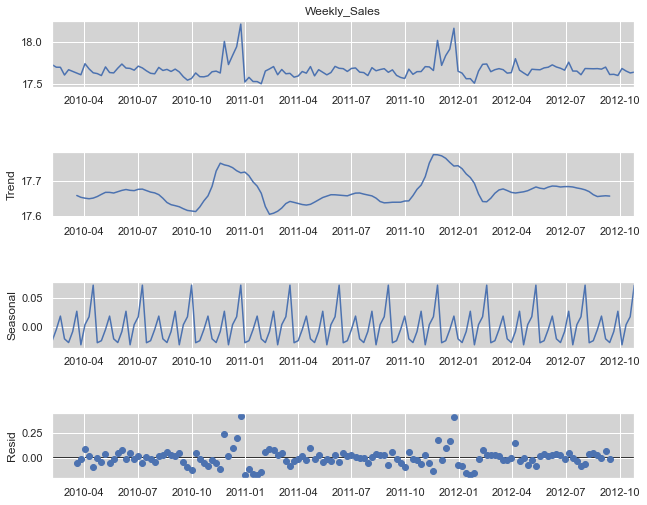

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decomp = seasonal_decompose(log_transformed_sales, period=12)

# Plot decomposition
figure = plt.figure()
figure = seasonal_decomp.plot()
figure.set_size_inches(10, 8)
plt.show()

Eventhough our transformed time series data is stationary, it exhibits seasonality which would need to be dealt with before being able to fit any ARIMA models.

### Model Selection and Fitting

We will now go ahead and fit a model to forecast weekly sales across all Walmart Stores and Departments from our training data. First, we must  evaluate the optimal model to fit before being able use it to generate forecasts from our data.

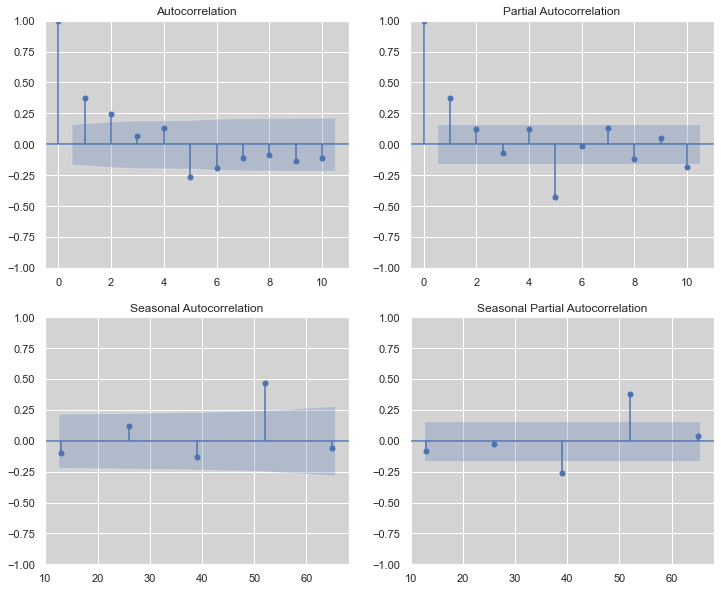

In [26]:
import warnings
warnings.filterwarnings("ignore")

# Plotting the ACF and PACF together to assess which order ARIMA model to select
figure, axes = plt.subplots(2,2, figsize = (12,10))

# Plot the regular ACF using 20 at most lags
plot_acf(log_transformed_sales, lags=10, ax=axes[0,0])
axes[0,0].set_title('Autocorrelation')

# Plot the regular PACF using 20 at most lags
plot_pacf(log_transformed_sales, lags=10, ax=axes[0,1])
axes[0,1].set_title('Partial Autocorrelation')

# Plot the seasonal ACF with up to 65 lags
plot_acf(log_transformed_sales, lags=[13*i for i in range(1,6)], ax=axes[1,0])
axes[1,0].set_title('Seasonal Autocorrelation')

# Plot the seasonal PACF with up to 65 lags
plot_pacf(log_transformed_sales, lags=[13*i for i in range(1,6)], ax=axes[1,1])
axes[1,1].set_title('Seasonal Partial Autocorrelation')

plt.show()

The regular ACF and PACF plots cut-off after 2 and 1 lag respectively. Furthermore, the seasonal ACF and seasonal PACF plots cut off at 4 and 3 lags respectively for a seasonal component of 13, since we have seasonal patterns repeating 4 times in a year (or every 13 out of 52 weeks). Lastly, since we already confirmed stationarity from the ADFuller Test we previously ran, we do not need to difference our time series.

In all, we will fit a SARIMAX model with the following parameters:

**p = 2, d = 0, q = 1, P = 3, D = 0, Q = 4, S = 13**

In [27]:
#Model instantiatio4
aggregate_weekly_sales_model = SARIMAX(log_transformed_sales, order = (2,0,1), seasonal_order = (3,0,4,13), 
                                     exog = df_train_grouped['IsHoliday'])

#Model Fitting
resulting_aggregate_weekly_sales = aggregate_weekly_sales_model.fit()

#Model Summary
print(resulting_aggregate_weekly_sales.summary())

                                           SARIMAX Results                                           
Dep. Variable:                                  Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(2, 0, 1)x(3, 0, [1, 2, 3, 4], 13)   Log Likelihood                  31.222
Date:                                       Wed, 30 Nov 2022   AIC                            -38.444
Time:                                               17:33:43   BIC                             -2.890
Sample:                                           02-05-2010   HQIC                           -23.997
                                                - 10-26-2012                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IsHoliday     -0.2424     

In [28]:
#In-Sample Predictions
in_sample_predictions = resulting_aggregate_weekly_sales.predict()

In [29]:
#Future Forecasts

steps = 39 #forecase 39 weeks into the future
future_forecast = resulting_aggregate_weekly_sales.forecast(steps, exog = df_test['IsHoliday'].values)

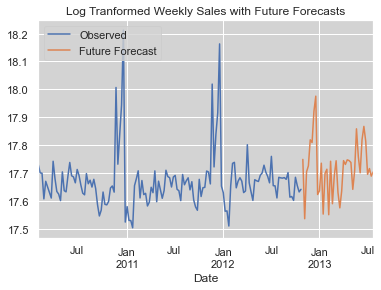

In [30]:
plt.title('Log Tranformed Weekly Sales with Future Forecasts')
log_transformed_sales.plot(label = 'Observed')
future_forecast.plot(label = 'Future Forecast')
plt.legend(loc = 'upper left')
plt.show()

### Model Diagnostics

In [31]:
print('Mean Absolute Error of the fitted SARIMA model = {}'.format(np.mean(abs(resulting_aggregate_weekly_sales.resid))))

Mean Absolute Error of the fitted SARIMA model = 0.30899099453276124


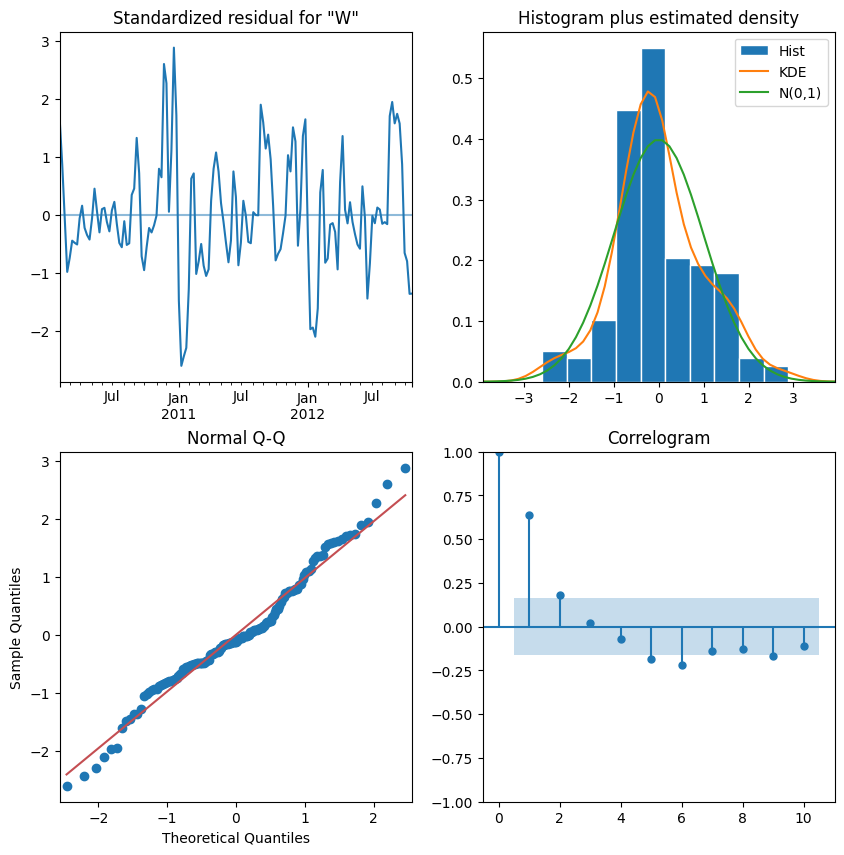

In [32]:
plt.rcParams.update(plt.rcParamsDefault)
resulting_aggregate_weekly_sales.plot_diagnostics(figsize = (10,10))
plt.show()

## Fitting Alternate Non-Time-Series Regression Models

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [34]:
df_train_non_tsa = pd.concat([pd.get_dummies(df_train['Store'], drop_first = True, prefix = 'store'), 
                        pd.get_dummies(df_train['Dept'], drop_first = True, prefix = 'dept'),
                             df_train], axis = 1).reset_index().drop(columns = ['Store', 'Dept', 'Date'])

df_train_non_tsa.describe()[['Weekly_Sales', 'Size', 'Temperature']]

,Weekly_Sales,Size,Temperature
count,421570.000000,421570.000000,421570.000000
mean,16101.304229,136727.915739,60.311183
std,22629.362424,60980.583328,17.737183
min,1000.000000,34875.000000,5.540000
25%,2079.757500,93638.000000,47.880000
50%,7612.030000,140167.000000,62.030000
75%,20205.852500,202505.000000,73.710000
max,693099.360000,219622.000000,100.140000


In [35]:
#create a dataframe for analysis, ignoring the time component and converting categorical variables to dummy variables
df_train_non_tsa = pd.concat([pd.get_dummies(df_train['Store'], drop_first = True, prefix = 'store'), 
                        pd.get_dummies(df_train['Dept'], drop_first = True, prefix = 'dept'),
                             df_train], axis = 1).reset_index().drop(columns = ['Store', 'Dept', 'Date'])

#Parameters for defining train and test sets
train_prop = int(0.85*df_train_non_tsa.shape[0])
train_predictors = [col for col in df_train_non_tsa.columns if col != 'Weekly_Sales']

#Creating train and test sets from our data
X_train = df_train_non_tsa[train_predictors].loc[:train_prop+1, :].values
y_train = df_train_non_tsa[['Weekly_Sales']].loc[:train_prop+1, :].values
X_test = df_train_non_tsa[train_predictors].loc[train_prop+1:, :].values
y_test = df_train_non_tsa[['Weekly_Sales']].loc[train_prop+1:, :].values

#normalizing all numeric columns to reduce effect of ourliers
# no_dummy_cols = sum([1 for name in df_train_non_tsa.columns if 'store' in name or 'dept' in name])

In [36]:
#normalizing all numeric columns to reduce effect of ourliers

# X_train[:, no_dummy_cols+1:] = sc.fit_transform(X_train[:, no_dummy_cols+1:])
# X_test[:, no_dummy_cols+1:] = sc.fit_transform(X_test[:, no_dummy_cols+1:])
# sc = StandardScaler()
# y_train = sc.fit_transform(y_train)
# y_test = sc.transform(y_test)

In [37]:
print('X_train has {} observations and {} columns'.format(X_train.shape[0], X_train.shape[1]))
print('X_test has {} observations and {} columns'.format(X_test.shape[0], X_test.shape[1]))
print('Y_train has {} observations'.format(y_train.shape[0]))
print('Y_test has {} observations'.format(y_test.shape[0]))

X_train has 358336 observations and 127 columns
X_test has 63235 observations and 127 columns
Y_train has 358336 observations
Y_test has 63235 observations


## Linear Regression Model Fit

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print('The Multiple Linear Regression Model has an R_2 score of {}'.format(r2_score(y_test, y_pred_lr)))

The Multiple Linear Regression Model has an R_2 score of 0.5635731557171326


## Decision Tree Regressor

In [39]:
dtr = DecisionTreeRegressor(min_samples_split = 10, min_samples_leaf = 5, random_state = 10)
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)


print('The Decision-Tree Regression Model has an R_2 score of {}'.format(r2_score(y_test, y_pred_dtr)))

The Decision-Tree Regression Model has an R_2 score of 0.579548892523202


## XGBoost Regressor

In [40]:
xgb_model = XGBRegressor(learning_rate = 0.05, n_estimators = 500, reg_lambda = 1.25)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


print('The XGBoostRegressor has an R_2 score of {}'.format(r2_score(y_test, y_pred_xgb)))

The XGBoostRegressor has an R_2 score of 0.7254210485486815


## Largest and Smallest Quarter-Quarter Sales % Increase or Decline Estimation

In [41]:
#Quarterly Sales prediction
df_train_quarterly = df_train.groupby(['Store','Dept']).resample('Q').sum()
df_train_quarterly.drop(columns = ['IsHoliday', 'Size', 'Temperature'], inplace = True)
df_train_quarterly.rename(columns = {'Weekly_Sales':'Quarterly_Sales'}, inplace = True)
df_train_quarterly = df_train_quarterly.reset_index(level = [2])
df_train_quarterly

Date  Quarterly_Sales
Store Dept                            
1     1    2010-03-31        223200.22
      1    2010-06-30        283951.61
      1    2010-09-30        218407.09
      1    2010-12-31        400789.81
      1    2011-03-31        277732.56
...               ...              ...
45    98   2011-12-31         13311.52
      98   2012-03-31         13000.00
      98   2012-06-30         13000.00
      98   2012-09-30         13000.00
      98   2012-12-31          4137.82

[37879 rows x 2 columns]

In [42]:
#Estimating Quarter-Quarter sales percentage changes for all stores and departments

sales_percent_change = []

for (store,dept) in df_train_quarterly.index.unique():
    sales_percent_change.append(df_train_quarterly.loc[(store,dept), 'Quarterly_Sales'].pct_change().mul(100).values)

df_train_quarterly = df_train_quarterly.reset_index()
df_train_quarterly['% change in Q-Q Sales'] = pd.Series(np.concatenate(sales_percent_change))
df_train_quarterly.replace(to_replace = {np.inf:np.nan, -np.inf:np.nan}, inplace = True)
df_train_quarterly.dropna(inplace = True)
df_train_quarterly

,Store,Dept,Date,Quarterly_Sales,% change in Q-Q Sales
1,1,1,2010-06-30,283951.61,27.218338
2,1,1,2010-09-30,218407.09,-23.082989
3,1,1,2010-12-31,400789.81,83.505861
4,1,1,2011-03-31,277732.56,-30.703687
5,1,1,2011-06-30,296287.24,6.680772
...,...,...,...,...,...
37874,45,98,2011-12-31,13311.52,-5.950379
37875,45,98,2012-03-31,13000.00,-2.340229
37876,45,98,2012-06-30,13000.00,0.000000
37877,45,98,2012-09-30,13000.00,0.000000


In [43]:
#Largest Q-Q Sales% increase
print('Store and Dept with largest Q-Q Sales percentage increase \n')
print(df_train_quarterly.loc[df_train_quarterly['% change in Q-Q Sales'].idxmax(), ['Store', 'Dept']])

print('\n')

#Largest Q-Q Sales% decline
print('Store and Dept with largest Q-Q Sales percentage decrease \n')
print(df_train_quarterly.loc[df_train_quarterly['% change in Q-Q Sales'].idxmin(), ['Store', 'Dept']])

Store and Dept with largest Q-Q Sales percentage increase 

Store    12
Dept     18
Name: 9765, dtype: object


Store and Dept with largest Q-Q Sales percentage decrease 

Store     1
Dept     45
Name: 501, dtype: object


## Conclusions

### Our analysis leads us to conclude the following:

Department 99 in Store 24 experienced the greatest Quarter-to Quarter sales % increase of all the Walmart stores and Departments in our analysis.

Department 19 in Store 41 experienced the greatest Quarter-to Quarter sales % decrease of all the Walmart stores and Departments in our analysis.